In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from itertools import chain 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model

import pingouin as pg

from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


In [2]:
pip install -U keras-tuner

  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-py3-none-any.whl size=78942 sha256=5e6a232f4fb55839b3c659ba1e6957513a4b8ec8dac05c961c1c62988d240ba4
  Stored in directory: c:\users\larsen\appdata\local\pip\cache\wheels\53\3d\c3\160c686bd74a18989843fcd015e8f6954ca8d834fd2ef4658a
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15357 sha256=c71260a68b9f5938ecdaea736e8b36926a95956adae1ae1a6bfcbc509a7a4849
  Stored in directory: c:\users\larsen\appdata\local\pip\cache\wheels\08\8f\5f\253d0105a55bd84ee61ef0d37dbf70421e61e0cd70cef7c5e1
Successfully built keras-tuner terminaltables
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv("data/all_normalized.csv")
df.head()

X_all = df.drop(['max_hr', 'vo2_l_min', 'vo2_ml_kg_min', 'Unnamed: 0'], axis=1)
y_hr = df['max_hr']
y_vo2 = df['vo2_ml_kg_min']

In [24]:
X_hr = ['ageattest', 'resting_hr', 'height inch->cm',
           'resting_sbp', 'resting_dbp', 'weight Ib->kg']
X = X_all[X_hr]

In [25]:
X.head()

,ageattest,resting_hr,height inch->cm,resting_sbp,resting_dbp,weight Ib->kg
0,0.322812,0.318182,0.666821,0.381818,0.525000,0.268406
1,0.509326,0.456250,0.254439,0.380273,0.484375,0.291403
2,0.609756,0.456250,0.208275,0.380273,0.484375,0.216546
3,0.236729,0.704545,0.450980,0.380273,0.484375,0.183053
4,0.552367,0.409091,0.647059,0.345455,0.425000,0.237614


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_hr), test_size=0.25, random_state=69)

X.head()

,ageattest,resting_hr,height inch->cm,resting_sbp,resting_dbp,weight Ib->kg
0,0.322812,0.318182,0.666821,0.381818,0.525000,0.268406
1,0.509326,0.456250,0.254439,0.380273,0.484375,0.291403
2,0.609756,0.456250,0.208275,0.380273,0.484375,0.216546
3,0.236729,0.704545,0.450980,0.380273,0.484375,0.183053
4,0.552367,0.409091,0.647059,0.345455,0.425000,0.237614


In [125]:
def build_model(hp):
    model = keras.Sequential()
    
    # input layer
    model.add(Dense(6,  activation='relu')) # 112
    
    # hidden 1
    model.add(Dense(units=hp.Int('units_1',
                                    min_value=2,
                                    max_value=12,
                                    step=1),
                       activation='relu'))
    model.add(Dropout(rate=hp.Float(
                'dropout_1',
                min_value=0.0,
                max_value=0.5,
                default=0.2,
                step=0.05,)))
    
    # hidden 2
    model.add(Dense(units=hp.Int('units_2',
                                    min_value=2,
                                    max_value=12,
                                    step=1),
                       activation='relu'))
    model.add(Dropout(rate=hp.Float(
                'dropout_2',
                min_value=0.0,
                max_value=0.5,
                default=0.2,
                step=0.05,)))

    # output layer
    model.add(Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    
    return model

In [129]:
tuner = RandomSearch(
    build_model,
    objective="mse",
    max_trials=10,
    executions_per_trial=5,
    # directory='/keras',
    project_name='test_tuner3')

In [130]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 12, 'step': 1, 'sampling': None}
dropout_1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 12, 'step': 1, 'sampling': None}
dropout_2 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [131]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 31s]
mse: 2654.97451171875

Best mse So Far: 662.4161987304688
Total elapsed time: 00h 05m 28s
INFO:tensorflow:Oracle triggered exit


In [132]:
models = tuner.get_best_models(num_models=2)

In [133]:
tuner.results_summary()

Results summary
Results in .\test_tuner3
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units_1: 6
dropout_1: 0.4
units_2: 9
dropout_2: 0.05
learning_rate: 0.01
Score: 662.4161987304688
Trial summary
Hyperparameters:
units_1: 11
dropout_1: 0.35000000000000003
units_2: 4
dropout_2: 0.2
learning_rate: 0.01
Score: 1696.7288818359375
Trial summary
Hyperparameters:
units_1: 9
dropout_1: 0.1
units_2: 6
dropout_2: 0.4
learning_rate: 0.01
Score: 2654.97451171875
Trial summary
Hyperparameters:
units_1: 4
dropout_1: 0.0
units_2: 12
dropout_2: 0.45
learning_rate: 0.01
Score: 2797.50078125
Trial summary
Hyperparameters:
units_1: 3
dropout_1: 0.30000000000000004
units_2: 9
dropout_2: 0.4
learning_rate: 0.01
Score: 3146.199951171875
Trial summary
Hyperparameters:
units_1: 11
dropout_1: 0.30000000000000004
units_2: 8
dropout_2: 0.35000000000000003
learning_rate: 0.001
Score: 3788.859228515625
Trial summary
Hyperparameters:
units_1: 12
dropout_1: 0.3500000

In [134]:
models[0].get_layer(name=None, index=1)

In [135]:
models[0].fit(x=X_train, 
          y=y_train, 
          epochs=250, # drgac dej 500
          batch_size=128,
          validation_data=(X_test, y_test), 
          )

Epoch 1/250

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

126/126 [==============================] - 0s 3ms/step - loss: 528.9792 - mse: 528.9792 - val_loss: 544.7789 - val_mse: 544.7789
Epoch 2/250
126/126 [==============================] - 0s 1ms/step - loss: 523.5227 - mse: 523.5227 - val_loss: 560.0392 - val_mse: 560.0392
Epoch 3/250
126/126 [==============================] - 0s 1ms/step - loss: 527.6749 - mse: 527.6749 - val_loss: 575.1215 - val_mse: 575.1215
Epoch 4/250
126/126 [==============================] - 0s 1ms/step - loss: 518.6352 -

Epoch 54/250
126/126 [==============================] - 0s 1ms/step - loss: 459.9561 - mse: 459.9561 - val_loss: 404.0985 - val_mse: 404.0985
Epoch 55/250
126/126 [==============================] - 0s 2ms/step - loss: 457.4900 - mse: 457.4900 - val_loss: 423.7068 - val_mse: 423.7068
Epoch 56/250
126/126 [==============================] - 0s 2ms/step - loss: 455.6062 - mse: 455.6062 - val_loss: 424.3611 - val_mse: 424.3611
Epoch 57/250
126/126 [==============================] - 0s 2ms/step - loss: 451.3091 - mse: 451.3091 - val_loss: 411.5625 - val_mse: 411.5625
Epoch 58/250
126/126 [==============================] - 0s 1ms/step - loss: 454.1825 - mse: 454.1825 - val_loss: 399.2473 - val_mse: 399.2473
Epoch 59/250
126/126 [==============================] - 0s 1ms/step - loss: 441.1125 - mse: 441.1125 - val_loss: 449.0753 - val_mse: 449.0753
Epoch 60/250
126/126 [==============================] - 0s 2ms/step - loss: 457.5646 - mse: 457.5646 - val_loss: 430.9441 - val_mse: 430.9441
Epoch 

126/126 [==============================] - 0s 2ms/step - loss: 410.2389 - mse: 410.2389 - val_loss: 402.6096 - val_mse: 402.6096
Epoch 112/250
126/126 [==============================] - 0s 2ms/step - loss: 407.2122 - mse: 407.2122 - val_loss: 372.6385 - val_mse: 372.6385
Epoch 113/250
126/126 [==============================] - 0s 2ms/step - loss: 414.7919 - mse: 414.7919 - val_loss: 429.6079 - val_mse: 429.6079
Epoch 114/250
126/126 [==============================] - 0s 1ms/step - loss: 405.9593 - mse: 405.9593 - val_loss: 376.4491 - val_mse: 376.4491
Epoch 115/250
126/126 [==============================] - 0s 1ms/step - loss: 405.5409 - mse: 405.5409 - val_loss: 433.9598 - val_mse: 433.9598
Epoch 116/250
126/126 [==============================] - 0s 1ms/step - loss: 405.2940 - mse: 405.2940 - val_loss: 406.3065 - val_mse: 406.3065
Epoch 117/250
126/126 [==============================] - 0s 1ms/step - loss: 409.6007 - mse: 409.6007 - val_loss: 437.4137 - val_mse: 437.4137
Epoch 118/250

Epoch 168/250
126/126 [==============================] - 0s 1ms/step - loss: 379.9618 - mse: 379.9618 - val_loss: 372.1255 - val_mse: 372.1255
Epoch 169/250
126/126 [==============================] - 0s 1ms/step - loss: 378.6610 - mse: 378.6610 - val_loss: 370.1168 - val_mse: 370.1168
Epoch 170/250
126/126 [==============================] - 0s 1ms/step - loss: 377.5842 - mse: 377.5842 - val_loss: 365.3550 - val_mse: 365.3550
Epoch 171/250
126/126 [==============================] - 0s 1ms/step - loss: 381.1301 - mse: 381.1301 - val_loss: 368.0190 - val_mse: 368.0190
Epoch 172/250
126/126 [==============================] - 0s 1ms/step - loss: 380.3638 - mse: 380.3638 - val_loss: 393.1656 - val_mse: 393.1656
Epoch 173/250
126/126 [==============================] - 0s 1ms/step - loss: 376.8545 - mse: 376.8545 - val_loss: 379.7930 - val_mse: 379.7930
Epoch 174/250
126/126 [==============================] - 0s 1ms/step - loss: 375.7163 - mse: 375.7163 - val_loss: 389.1494 - val_mse: 389.1494

126/126 [==============================] - 0s 2ms/step - loss: 359.7862 - mse: 359.7862 - val_loss: 378.1994 - val_mse: 378.1994
Epoch 226/250
126/126 [==============================] - 0s 2ms/step - loss: 359.4084 - mse: 359.4084 - val_loss: 378.3944 - val_mse: 378.3944
Epoch 227/250
126/126 [==============================] - 0s 2ms/step - loss: 360.0649 - mse: 360.0649 - val_loss: 356.2045 - val_mse: 356.2045
Epoch 228/250
126/126 [==============================] - 0s 2ms/step - loss: 352.6383 - mse: 352.6383 - val_loss: 384.6695 - val_mse: 384.6695
Epoch 229/250
126/126 [==============================] - 0s 2ms/step - loss: 356.8366 - mse: 356.8366 - val_loss: 372.2302 - val_mse: 372.2302
Epoch 230/250
126/126 [==============================] - 0s 2ms/step - loss: 355.0925 - mse: 355.0925 - val_loss: 359.9736 - val_mse: 359.9736
Epoch 231/250
126/126 [==============================] - 0s 2ms/step - loss: 356.3480 - mse: 356.3480 - val_loss: 363.1832 - val_mse: 363.1832
Epoch 232/250

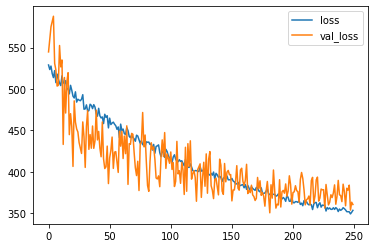

In [136]:
losses = pd.DataFrame(models[0].history.history)
losses[['loss','val_loss']].plot()

------------------------------
OVERALL RRMSE
0.8621549695075315
OVERALL RMSE
18.986114762379255


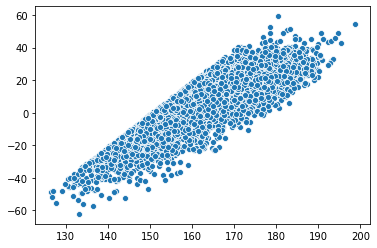

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y_hr), test_size=0.25, random_state=15)

res_nn = models[0].predict(X_test)
RRMSE_max_hr = 1 - r2_score(y_test, res_nn)
print("------------------------------")
print("OVERALL RRMSE")
print(RRMSE_max_hr)
print("OVERALL RMSE")
print(math.sqrt(mean_squared_error(y_test, res_nn)))

y_res = list(chain.from_iterable(res_nn))

# BLAND-ALTMAN plot
sns.scatterplot(x=((y_test + y_res) / 2), y=(y_test - y_res))